In [ ]:
# imports
# load data Nxn_dim
# tsne n_dim -> 2
# nn n_dim -> 2
# print loss

In [1]:
import database
from dataset import Dataset
from ae_test import AutoencoderTest
import torch.optim as optim
import torch
from tqdm import tqdm_notebook
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import os
from sklearn import manifold 
# 如果想要import 子文件下的py檔，需要在子文件下建立一個__init__.py，可以爲空
# import plt.plt_hist as plt_hist
import matplotlib.pyplot as plt
import matplotlib
from ae_test import AutoencoderTest
from sklearn.externals import joblib

In [16]:
distance_matrix = torch.load('distance_map/bike_sharing_pre_compute_distance_matrix_temp.pth')
distance_matrix_mean = distance_matrix.mean()
print(distance_matrix_mean)

tensor(1.0001)


In [17]:
# train.py test3
distance_matrix[distance_matrix > 1.5] = 1.5
test3_distance_matrix = distance_matrix
test3_mean = test3_distance_matrix.mean()
print(test3_mean)

tensor(0.9628)


In [9]:
# train.py test2
test2_distance_matrix = 1/(-(distance_matrix+0.874)**3)+1.5
test2_mean = test2_distance_matrix.mean()
print(test2_mean)

tensor(1.3169)


In [6]:
distance_matix[distance_matix<=1] = (1/-(distance_matix[distance_matix<=1] +1)**6)+1
mean = distance_matix.mean()
print(mean)

tensor(1.1470)


In [2]:
device = torch.device('cuda')
BATCH_SIZE = 64
LEARNING_RATE = 1e-4

In [3]:
dataset_name = 'bike_sharing'
pre_sort = 'sort/'+dataset_name+'_sort.pth'

In [4]:
# 資料庫連接設定
db = database.DEFAULT_DB()
db.setUp()

In [5]:
# 資料集資料載入
dataset = Dataset(db,dataset_name)
dataset.set_columns(columns=['temp','hum','casual','windspeed','registered','cnt'])
dataset.load(BATCH_SIZE,1,1,all_level=True)
rawdata = dataset.rawdata
normalizer = dataset.normalizer
MAX_EPOCH = 100 // len(dataset.dataloader) + 1
INPUT_DIM = len(dataset.columns)
mse_each = nn.MSELoss()
normalizer_data = normalizer.transform(rawdata)
print(normalizer_data.shape)

new dataset: bike_sharing
(17379, 6)


In [6]:
model = nn.Sequential(
        nn.Linear(INPUT_DIM, 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256, 128),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(128, 64),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(64, 32),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(32, 8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(8, 2)).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [9]:
# tsne test
tsne = manifold.TSNE(n_components=2, perplexity=100, init='random', random_state=501)
if os.path.exists("tsne_output.pth"):
    tsne_embed = torch.load("tsne_output.pth")
else:
    tsne_embed = tsne.fit_transform(normalizer.transform(rawdata))
    torch.save(tsne_embed,"tsne_output.pth")

In [7]:
# mds test
mds = manifold.MDS(n_components=2, dissimilarity='euclidean', metric=True)
if os.path.exists("mds_output.pth"):
    mds_embed = torch.load("mds_output.pth")
else:
    mds_embed = mds.fit_transform(normalizer_data.astype(np.float64))
    torch.save(mds_embed,"mds_output.pth")

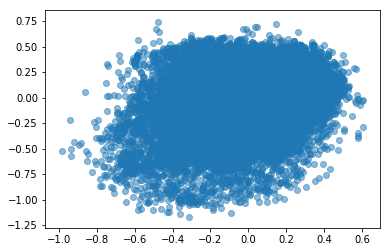

In [8]:
# 繪製 mds 結果的scatter plot
plt.scatter(mds_embed[:,0], mds_embed[:,1], alpha=.5)

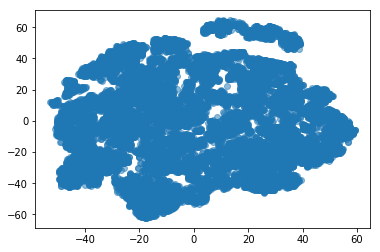

In [10]:
# 繪製 tsne 結果的scatter plot
plt.scatter(tsne_embed[:,0], tsne_embed[:,1], alpha=.5)

In [ ]:
tsne_embed = torch.Tensor(tsne_embed)
training_data = torch.cat((torch.Tensor(normalizer.transform(rawdata)), tsne_embed), dim=1)

In [ ]:
dataloader = torch.utils.data.DataLoader(training_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    pin_memory=True)

In [ ]:
for epoch in tqdm_notebook(range(2000)):
    with tqdm_notebook(dataloader, leave=False) as t:
        for data in t:
            input_data,output_data = data[:, :INPUT_DIM],data[:,INPUT_DIM:]
            input_data = input_data.to(device)
            output_data = output_data.to(device)
            optimizer.zero_grad()
            loss = mse_each(model(input_data),output_data)
            t.set_description('{}'.format(loss.item()))
            loss.backward()
            optimizer.step()

In [ ]:
torch.save(model.state_dict(),"nn_tsne.pth")